# Práctico 1: Recomendación de Artistas

En este práctico trabajaremos con el conjuto de datos de [LastFM](https://grouplens.org/datasets/hetrec-2011/) para el desarrollo de un sistema de recomendación que, dado el nombre de un artista musical, devuelve una lista de artistas "similares".

Para el práctico utilizaremos el conjunto de datos de LastFM que consiguieron del [notebook de instalación](./instalacion.ipynb). Se recomienda leer el [Readme](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt) de los datos para saber más sobre que información contiene cada archivo.

La idea del práctico es hacer un análisis muy sencillo del conjunto de datos y desarrollar un sistema de recomendación basado en filtrado colaborativo (usando Surpr!se), a partir de los datos existentes.

In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from surprise import Dataset, Reader
from surprise.accuracy import rmse
from surprise.model_selection import cross_validate, train_test_split
from surprise import SVD
from surprise import SVDpp
from surprise import SlopeOne
from surprise import NMF
from surprise import NormalPredictor
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import CoClustering
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import os
BASE_PATH = os.getcwd().replace("\\", "/")

In [154]:
artist_data = pd.read_csv(BASE_PATH + "/data/lastfm/artists.dat", sep="\t")
artist_data.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [155]:
user_artist_plays = pd.read_csv(BASE_PATH + "/data/lastfm/user_artists.dat", sep="\t")
user_artist_plays.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


## Ejercicio 1 - Análisis Exploratorio de Datos

En esta primera parte deberán hacer un análisis exploratorio de los datos, aprovechando toda la información brindada por el conjunto. A partir de eso podrán tener mayor idea de qué tipo de datos estarán enfrentando (describe o hist).

Algunas preguntas para responder:
- ¿Cuáles son los artistas que fueron más escuchados?
- ¿Cómo es la distribución de cantidad de listens por user?
- ¿Es posible ver el género más escuchado?

In [156]:
# ¿Cuáles son los artistas que fueron más escuchados?

most_listened_artists = user_artist_plays.groupby(["artistID"]).agg({"weight": "sum"})
most_listened_artists_by_name = pd.merge(
    left=most_listened_artists, right=artist_data,
    left_on="artistID",         right_on="id")
top_10_most_listened_artists_by_name = most_listened_artists_by_name[["name", "weight"]].sort_values("weight", ascending=False).head(10)
display(top_10_most_listened_artists_by_name)

,name,weight
283,Britney Spears,2393140
66,Depeche Mode,1301308
83,Lady Gaga,1291387
286,Christina Aguilera,1058405
492,Paramore,963449
61,Madonna,921198
282,Rihanna,905423
695,Shakira,688529
221,The Beatles,662116
294,Katy Perry,532545


,weight
userID,
2,168737
3,20501
4,26930
5,13159
6,1011


,count,mean,std,min,25%,50%,75%,max
weight,1892.0,36566.582981,48744.552394,3.0,9742.25,21573.0,42963.75,480039.0


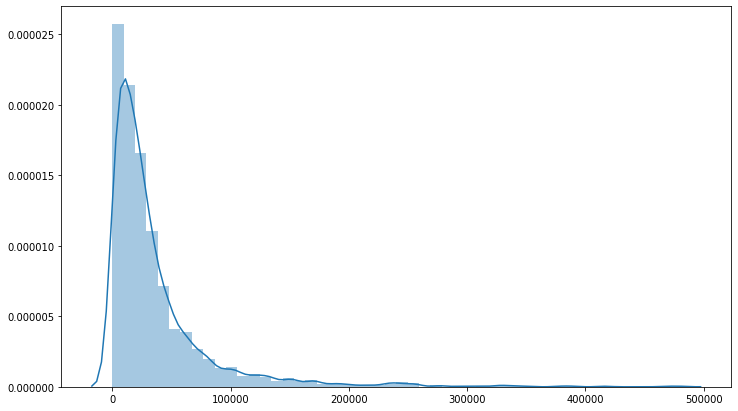

In [157]:
# ¿Cómo es la distribución de cantidad de listens por user?

listens_per_user = user_artist_plays.groupby(["userID"]).agg({"weight": "sum"})
display(listens_per_user.head())
display(listens_per_user.describe().T)
plt.figure(figsize=(12, 7))
sns.distplot(listens_per_user)

In [158]:
# ¿Es posible ver el género más escuchado?
tags = pd.read_csv(BASE_PATH + '/data/lastfm/tags.dat', sep = '\t', encoding = 'latin-1')
user_taggedartists = pd.read_csv(BASE_PATH + '/data/lastfm/user_taggedartists.dat', sep = '\t')

# display(tags.head())
# display(user_taggedartists.head())

genre_listens_count = user_taggedartists.groupby(["tagID"]).agg({"tagID": "count"}).rename(columns={'tagID':'weight'})
artist_tagged_by_genre = pd.merge(
    left=tags, right=genre_listens_count,
    left_on="tagID",         right_on="tagID")
# display(artist_tagged_by_genre.head())

top_10_most_listened_genre = artist_tagged_by_genre.sort_values("weight", ascending=False).head(10)
# display(top_10_most_listened_genre)

print("The most listened genre is: \n", top_10_most_listened_genre.tagValue.head(1))

The most listened genre is: 
 71    rock
Name: tagValue, dtype: object


## Ejercicio 2 - Matriz de Usuario-Contenido

En este ejercicio, a partir del conjunto de datos, deberán generar una matriz de usuario-contenido. Tengan en cuenta que los ratings, en este caso, son implícitos, puesto que se dan a partir de la cantidad de veces que un usuario escuchó a cierto artista.

In [159]:
user_artist_plays = pd.merge(
    left=user_artist_plays, right=listens_per_user,
    left_on="userID",       right_on="userID", how="inner")
user_artist_plays.rename(columns={"weight_x": "weight", "weight_y": "repros"}, inplace=True)

In [172]:
user_artist_plays["weight_norm"] = user_artist_plays["weight"] / user_artist_plays["repros"]
user_artist_plays

,userID,artistID,weight,repros,weight_norm
0,2,51,13883,168737,0.082276
1,2,52,11690,168737,0.069279
2,2,53,11351,168737,0.067270
3,2,54,10300,168737,0.061042
4,2,55,8983,168737,0.053237
...,...,...,...,...,...
92829,2100,18726,337,30877,0.010914
92830,2100,18727,297,30877,0.009619
92831,2100,18728,281,30877,0.009101
92832,2100,18729,280,30877,0.009068


In [185]:
user_artist_plays[["weight", "repros", "weight_norm"]].describe()

,weight,repros,weight_norm
count,92834.00000,92834.000000,92834.000000
mean,745.24393,37074.173212,0.020380
std,3751.32208,48934.678650,0.037348
min,1.00000,3.000000,0.000008
25%,107.00000,10143.000000,0.007759
50%,260.00000,21843.000000,0.012632
75%,614.00000,43897.000000,0.020974
max,352698.00000,480039.000000,1.000000


In [173]:
user_artist_plays_with_artistName = pd.merge(
    left=user_artist_plays, right=artist_data[["id", "name"]],
    left_on="artistID",     right_on="id")
del user_artist_plays_with_artistName["id"]
user_artist_plays_with_artistName

,userID,artistID,weight,repros,weight_norm,name
0,2,51,13883,168737,0.082276,Duran Duran
1,4,51,228,26930,0.008466,Duran Duran
2,27,51,85,5738,0.014814,Duran Duran
3,28,51,10,499,0.020040,Duran Duran
4,62,51,528,16660,0.031693,Duran Duran
...,...,...,...,...,...,...
92829,2100,18726,337,30877,0.010914,Nyktalgia
92830,2100,18727,297,30877,0.009619,Atsakau niekadA
92831,2100,18728,281,30877,0.009101,Domantas Razauskas
92832,2100,18729,280,30877,0.009068,Atalyja


In [176]:
user_content_matrix = pd.pivot_table(user_artist_plays_with_artistName, index = ['userID'], columns = ['name'], values = ['weight_norm'], aggfunc = sum, fill_value = 0)
user_content_matrix

weight_norm                                             \
name           !!! !DISTAIN !deladap ##### #2 Orchestra $lick   
userID                                                          
2              0.0      0.0      0.0   0.0          0.0   0.0   
3              0.0      0.0      0.0   0.0          0.0   0.0   
4              0.0      0.0      0.0   0.0          0.0   0.0   
5              0.0      0.0      0.0   0.0          0.0   0.0   
6              0.0      0.0      0.0   0.0          0.0   0.0   
...            ...      ...      ...   ...          ...   ...   
2095           0.0      0.0      0.0   0.0          0.0   0.0   
2096           0.0      0.0      0.0   0.0          0.0   0.0   
2097           0.0      0.0      0.0   0.0          0.0   0.0   
2099           0.0      0.0      0.0   0.0          0.0   0.0   
2100           0.0      0.0      0.0   0.0          0.0   0.0   

                                                                          ...  \
name   $lick feat. Six-Fo (1962-1966) (Pre) Kingdom (We Are) Performance  ...   
userID                                                                    ...   
2                     0.0         0.0           0.0                  0.0  ...   
3                     0.0         0.0           0.0                  0.0  ...   
4                     0.0         0.0           0.0                  0.0  ...   
5                     0.0         0.0           0.0                  0.0  ...   
6                     0.0         0.0           0.0                  0.0  ...   
...                   ...         ...           ...                  ...  ...   
2095                  0.0         0.0           0.0                  0.0  ...   
2096                  0.0         0.0           0.0                  0.0  ...   
2097                  0.0         0.0           0.0                  0.0  ...   
2099                  0.0         0.0           0.0                  0.0  ...   
2100                  0.0         0.0           0.0                  0.0  ...   

                                                                         \
name    티아라   현아 ＬｕＬｕ ＭＡＮＮＥＱＵＩＮ ＰＥＲＥＳＴＲＯＩＫＡ  ＲＥＤ ＶａｎｅｓｓＡ ｂｏｏｇｉｅｍａｎ ｂｏｒｎ   
userID                                                                    
2       0.0  0.0  0.0       0.0         0.0  0.0     0.0       0.0  0.0   
3       0.0  0.0  0.0       0.0         0.0  0.0     0.0       0.0  0.0   
4       0.0  0.0  0.0       0.0         0.0  0.0     0.0       0.0  0.0   
5       0.0  0.0  0.0       0.0         0.0  0.0     0.0       0.0  0.0   
6       0.0  0.0  0.0       0.0         0.0  0.0     0.0       0.0  0.0   
...     ...  ...  ...       ...         ...  ...     ...       ...  ...   
2095    0.0  0.0  0.0       0.0         0.0  0.0     0.0       0.0  0.0   
2096    0.0  0.0  0.0       0.0         0.0  0.0     0.0       0.0  0.0   
2097    0.0  0.0  0.0       0.0         0.0  0.0     0.0       0.0  0.0   
2099    0.0  0.0  0.0       0.0         0.0  0.0     0.0       0.0  0.0   
2100    0.0  0.0  0.0       0.0         0.0  0.0     0.0       0.0  0.0   

                
name   ｍａｃｈｉｎｅ  
userID          
2          0.0  
3          0.0  
4          0.0  
5          0.0  
6          0.0  
...        ...  
2095       0.0  
2096       0.0  
2097       0.0  
2099       0.0  
2100       0.0  

[1892 rows x 17632 columns]

In [178]:
# Dispersion

n_tot = user_content_matrix.shape[0] * user_content_matrix.shape[1]
n_rat = user_content_matrix.astype(bool).sum().sum()
sparsity = n_rat / n_tot

print(f"Matrix User-Content Sparsity: {round(sparsity * 100, 2)}%")

Matrix User-Content Sparsity: 0.28%


## Ejercicio 3 - Entrenamiento del algoritmo de recomendación

Utilizando las herramientas brindadas por Surpr!se, entrenen varios modelos de sistemas de recomendación basados en filtrado colaborativo a partir de su matriz de usuario-contenido. Recuerden tener en cuenta lo aprendido en la diplomatura a la hora de evaluar y validar el modelo.

Si necesitan inspiración, les recomiendo revisar [este notebook con información de como entrenar un sistema de recomendación con Surpr!se](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb).

In [186]:
reader = Reader(rating_scale = (user_artist_plays_with_artistName.weight_norm.min(), user_artist_plays_with_artistName.weight_norm.max()))

ratings = Dataset.load_from_df(user_artist_plays_with_artistName[['userID', 'artistID', 'weight_norm']], reader)

In [187]:
# Model Benchmark

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, ratings, measures = ['RMSE'], cv = 5, verbose = False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis = 0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index = ['Algorithm']))
    benchmark.append(tmp)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

In [188]:
# Best model

surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,0.036624,0.282580,0.185409
KNNBasic,0.037152,0.686398,2.316407
KNNBaseline,0.037608,0.970611,2.894207
KNNWithMeans,0.037934,0.764585,2.454211
SlopeOne,0.038037,12.993788,1.309013
KNNWithZScore,0.038988,0.908591,2.652199
CoClustering,0.042102,4.842407,0.142209
NMF,0.042114,8.068800,0.389415
SVDpp,0.044758,68.895335,1.578794


In [189]:
# BaselineOnly ALS (Alternating Least Squares)

model_als = BaselineOnly()
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.2)
predictions_als = model_als.fit(ratings_train).test(ratings_test)
print("RMSE on test: {:.4f}".format(rmse(predictions_als, verbose = False)))

Estimating biases using als...
RMSE on test: 0.0357


## Ejercicio 4 - Sistema de recomendación

A partir del mejor modelo de recomendación que hayan sugerido en el caso anterior, y utilizando los datos del archivo `artist.dat`, armar un sistema de recomendación sencillo que, dado un nombre de un artista, devuelva el top 10 de artistas más similares.

La idea es que el sistema tome el nombre de un artista y devuelva el nombre de otros artistas (no simplemente tomar y devolver IDs). Se recomienda [revisar este notebook para inspiración (ver el paso número 5)](https://github.com/topspinj/pydata-workshop/blob/master/tutorial.ipynb).

In [195]:
def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userID'].nunique()
    N = df['artistID'].nunique()

    user_mapper = dict(zip(np.unique(df['userID']), list(range(M))))
    artist_mapper = dict(zip(np.unique(df['artistID']), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df['userID'])))
    artist_inv_mapper = dict(zip(list(range(N)), np.unique(df['artistID'])))
    
    user_index = [user_mapper[i] for i in df['userID']]
    item_index = [artist_mapper[i] for i in df['artistID']]

    X = csr_matrix((df['weight_norm'], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, artist_mapper, user_inv_mapper, artist_inv_mapper

X, user_mapper, artist_mapper, user_inv_mapper, artist_inv_mapper = create_X(user_artist_plays_with_artistName)

In [196]:
X_user_content_matrix = pd.pivot_table(user_artist_plays_with_artistName, values='weight_norm', index='userID', columns='name').fillna(0)
X_user_content_matrix

name,!!!,!DISTAIN,!deladap,#####,#2 Orchestra,$lick,$lick feat. Six-Fo,(1962-1966),(Pre) Kingdom,(We Are) Performance,...,티아라,현아,ＬｕＬｕ,ＭＡＮＮＥＱＵＩＮ,ＰＥＲＥＳＴＲＯＩＫＡ,ＲＥＤ,ＶａｎｅｓｓＡ,ｂｏｏｇｉｅｍａｎ,ｂｏｒｎ,ｍａｃｈｉｎｅ
userID,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [199]:
# Dispersion

n_total = X_user_content_matrix.shape[0] * X_user_content_matrix.shape[1]
n_ratings = float(len(X_user_content_matrix.values.nonzero()[0]))
sparsity = n_ratings / n_total

print(f'Matrix sparsity: {round(sparsity * 100, 2)}%')

Matrix sparsity: 0.28%


In [201]:
# Item-item Recommendations using KNN

def find_similar_artists(artist_id, X, artist_mapper, artist_inv_mapper, k, metric = 'cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []
    
    artist_ind = artist_mapper[artist_id]
    artist_vec = X[artist_ind]
    
    if isinstance(artist_vec, (np.ndarray)):
        artist_vec = artist_vec.reshape(1,-1)
        
    # use k+1 since kNN output includes the artistID of interest
    kNN = NearestNeighbors(n_neighbors = k + 1, algorithm = 'brute', metric = metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(artist_vec, return_distance = False)
    
    for i in range(0, k):
        n = neighbour.item(i)
        neighbour_ids.append(artist_inv_mapper[n])
        
    neighbour_ids.pop(0)
    return neighbour_ids

In [204]:
def artist_finder(artist):
    return artist_data[artist_data['name'].str.contains(artist)]['name'].tolist()

artist_idx = dict(zip(artist_data['name'], list(artist_data.id)))

### Discover new music! Make your choise:

In [223]:
for artist in user_artist_plays_with_artistName.sort_values("name").name.unique():
    print(artist)

!!!
!DISTAIN
!deladap
#####
#2 Orchestra
$lick
$lick feat. Six-Fo
(1962-1966)
(Pre) Kingdom
(We Are) Performance
(hed) Planet Earth
(sic)monic
*NSYNC
+44
+\-
-123 min.
-OZ-
-t de sangre
...And The Earth Swarmed With Them
...And You Will Know Us by the Trail of Dead
.38 Special
.crrust
06 Children Of The Cross
08001
1-800-ZOMBIE
10 Years
10-20 БЕЗ ВЫХОДНЫХ
100 Bitches
1000names
100DEADRABBITS!!!
100blumen
100dBs
10cc
11.43
110
112
1125
12 Rounds
12 Stones
120 Days
1200 Micrograms
12012
127 Band
129- FLY PROJECT & TOM BOXER & ANCA PARGHEL
12th Planet
13
1349
13th Floor Elevators
14 Bis
14 Year Old Girls
16 Horsepower
16Volt
16bit
18th Dye
19
1910 Fruitgum Company
1974 AD
1990s
1994!
1997
1SaGain
2 0' Clock Girlfriend
2 Brothers on the 4th Floor
2 Many DJ's
2 Skinnee J's
2 Times Terror
2 Unlimited
2 Гига Любви
2002
2009 Broadway Revival Cast
2009 Names in Vain
21 hertz
213
25 LAT LISTY PRZEBOJÓW TRÓJKI
2562
2AM
2AM Club
2Face Idibia
2H Company
2NE1
2PM
2Pac
2gether
2nd II None
2ois
2up
3


Beulah
Beverley Knight
Beverly Kenney
Beyoncé
Beyoncé (I Am Tour@Edmonton)
Beyoncé e Alicia Keys
Beyoncé e Lady Gaga
Beyoncé | www.CdsCompletos.net
Beyoncé/Big Boi/Sleepy Brown
Beyond The Embrace
Beyond the Void
Bezerra Da Silva
Bezmârâ
Biagio Antonacci
Bianca Ryan
Bias
Bibio
Bidê ou Balde
Bielizna
Bif Naked
Biffy Clyro
Big & Rich
Big Bad Voodoo Daddy
Big Black
Big Boys
Big Brother & The Holding Company
Big Brotherz
Big Business
Big Country
Big D and the Kids Table
Big Dipper
Big Dismal
Big H
Big Japan
Big Joe Turner
Big L
Big Mama Thornton
Big Mama Thornton / Muddy Waters Blues Band
Big Mato
Big Maybelle
Big Mike
Big Moves
Big Punisher
Big Sandy & His Fly-Rite Boys
Big Sean
Big Star
Big Stuf
Big Sugar
Big Syke
Big Time Rush
Big Walter Horton
Big Weird Dutch People
Big Youth
Big Z Remixes
BigBang
Biglietto per l'Inferno
Bigwig
Bijelo Dugme
Bikini Kill
Bilal
Bilal Serbest
Bilge Pump
Bill
Bill Anderson
Bill Bailey
Bill Brown
Bill Bruford
Bill Callahan
Bill Cosby
Bill Elm and Woody Jackso

Cook Da Books
Cookie Monsta
Cool Calm Pete
Cool Hand Luke
Cool Kids of Death
Coordinated Chaos
Cop Shoot Cop
Copacabana Club
Copeland
Coph Nia
Coprofago
Cops on Fire
Coptic Rain
Cora
Coral Resgate
Corbin Bleu
Cordel do Fogo Encantado
Cordovero
Core Corp
Coresplittaz
Corey Smith
Corey Stevens
Corinne Bailey Rae
Cormega
Corn on Macabre
Cornelius
Corona
Coroner
Corpore
Corpus Christi
Corpus Delicti
Correatown
Corrientes
Corrosion of Conformity
Cortes
Corvus Corax
Cory Lee
Cory Monteith
Cosma
Cosmic Gate
Cosmic Gate feat. Emma Hewitt
Cosmic Rough Riders
Cosmicity
Cosmosis
Cotton Mather
Count Basie
Count Bass D
Count Dee's Hit Explosion
Counterparts
Counterstrike
Counterstrike & Current Value
Counting Crows
Countryside
Course for teenagers
Course of Nature
Court Yard Hounds
Courtney Love
Coven
Covenant
Coverdale/Page
Cowboy Junkies
Cowboy Prostitutes
Cowtown
Coyote Clean Up
Cracker
Cradle of Filth
Craig Armstrong
Craig David
Craig Owens
Cranes
Crash Anthem
Crash Test Dummies
CrashDďet
Crass

Fallen
Falling In Reverse
Falling Red
Falling Up
Fallulah
False Awakening
FaltyDL
Family Fantastic
Family Force 5
Fan Death
Fancy
Fanfarlo
Fang Island
Fangoria
Fanisk
FankaDeli
Fanny Lú
Fantan Mojah
Fantasia
Fantastic Plastic Machine
Fantazja
Fantômas
Far East Movement
Far Too Loud vs Code Zero
Faraquet
Farben Lehre
Fard
Fares Karam
Farewell
Farewell to Freeway
Farhad
Farhad As'adian
Farid Bang
Farid Farjad
Farin Urlaub
Fascination
Fashawn
Fashion
Fastball
Faster Pussycat
Fat Freddy's Drop
Fat Joe
Fat Jon
Fat Mattress
Fat Segal
Fatale
Fatali
Fatback Band
Fatboy Slim
Fates Warning
Fatih Yaşar
Fatih Çollak
Fatima Spar und die Freedom Fries
Fats Domino
Fats Waller
Fatso Jetson
Fatty Spins
Faun
Faun Fables
Faunts
Faust
Faust Again
Fauxliage
Favez
Favorite
Favorite & Hollywood Hank
Fax
Fear
Fear Before the March of Flames
Fear Factory
Fear Of Domination
Fede Comin y Fran Fernandez
Federico Miranda
Feed Her To The Sharks
Feed Me
Feeder
Feel
Fefe Dobson
Feindflug
Feist
Fela Kuti
Feldberg
Feli

Ike Quebec
Ike Yoshihiro
Ikimono-Gakari
Ikuko Kawai
Ikuta Toma
Ikuta Toma & KAT-TUN
Ikuta Toma & Yabu Kota
Il Divo
Il Paese dei Balocchi
Il Rovescio della Medaglia
Il Volo
Ilan Eshkeri
Ilario Alicante
Ildjarn
Ilian Filipov
Ilkae
Ilkka Alanko
Ill Niño
Illa J
Illdisposed
Illicit Love Parade
Illnath
Illogic
Illuminate
Illusion of Light
Iloyd
Im Tae Kyung
Imaad Wasif
Imad Al-Sharif
Images in Vogue
Imagica
Imagination
Imelda May
Immaculate Machine
Immanu El
Immediate Music
Imminent Starvation
Immortal
Immortal Technique
Imogen Heap
Impact
Impacto Cinco
Impaled
Impellitteri
Impending Doom
Imperanon
Imperative Reaction
Imperia
Imperial Crystalline Entombment
Imperium Dekadenz
Impetigo
In Blood We Trust
In Extremo
In Fear and Faith
In Flagranti
In Flames
In Irons
In Mourning
In My Rosary
In Slaughter Natives
In Strict Confidence
In This Moment
In the Midst of Lions
In the Nursery
In-Grid
In:aviate
InMe
InVekTiva
In[Perfektion]
Inachus
Inactive Messiah
Inara George
Incesaz
Incognito
Inconscient

Lordi
Lords of Acid
Lords of Decadence
Lordsong
Loredana Bertè
Loredana Errore
Loreena McKennitt
Lorena Simpson
Loretta Lynn
Lorette Velvette
Lori Meyers
Lorie
Lorraine
Lorrie Morgan
Los 007
Los Abuelos de la Nada
Los Amigos Invisibles
Los Angeles Guitar Quartet
Los Auténticos Decadentes
Los Brincos
Los Bunkers
Los Cadetes de Linares
Los Cafres
Los Campesinos!
Los Cinco Latinos
Los Concorde
Los Crudos
Los Desterrados
Los Fabulosos Cadillacs
Los Fantasmas del Caribe
Los Fastidios
Los Fresones Rebeldes
Los Hermanos
Los Jaivas
Los Lobos
Los Locos del Ritmo
Los Natas
Los Paranoias
Los Pericos
Los Piojos
Los Planetas
Los Prisioneros
Los Punsetes
Los Rabanes
Los Rodríguez
Los Shakers
Los Straitjackets
Los Tres
Los de Adentro
Loscil
Loser
Loss of a Child
Lost
Lost Balance
Lost Buddha
Lost Cherrees
Lost Horizon
Lost Signal
Lost Sounds
LostAlone
Lostprophets
Lotek
Lotus Plaza
Lou Barlow
Lou Rawls
Lou Reed
Lou Reed & John Cale
Loudon Wainwright III
Louis Armstrong
Louis Garrel & Clothilde Hesme


Odissea
Of Machines
Of Mice & Men
Of The Fallen
Of the Wand and the Moon
Off Minor
Off With Their Heads
Off the Sky
Offer Nissim
Offer Nissim feat. Maya
Offlaga Disco Pax
Oficina G3
Ofo The Black Company
Oh Land
Oh Laura
Oh No
Oh No Oh My
Oh The Blood
Oh, Sleeper
Ohbijou
Ohio Players
Oi Polloi
Oi Va Voi
Oidupaa Vladimir Oiun
Oil 10
Oingo Boingo
Ojciec Dyktator
Ojos de Brujo
Ok que
Okkervil River
Ol' Dirty Bastard
Ola
Ola Podrida
Ola Svensson
Olafur Arnalds
Olallo Rubio
Olavi Uusivirta
Old Crow Medicine Show
Old Man Shattered
Old Man's Child
Old Time Radio
Olho Seco
Oliver Koletzki
Oliver Koletzki/Florian Meindl
Oliver Pigott
Oliver Shanti
Oliver Shanti & Friends
Olivia
Olivia Newton-John
Olivia Ong
Olivia Ruiz
Olivier Deriviere
Olivier Messiaen
Ollabelle
Olli Mustonen
Olly Murs
Olu
Om
Omar A. Rodriguez-Lopez
Omar Faruk Tekbilek
Omarion
Omega
Omega Lithium
Omega Massif
Omnia
Omnimotion
On Solid Ground
On a Friday
Ondubground
One Be Lo
One Be Lo ft. J-Spliff
One Chance
One Day as a Lion


Rukkanor
Run Level Zero
Run-D.M.C.
Runaways
Runner Runner
Running Wild
Runsfasterscared
Ruoska
Rush
Rush - Power Windows
Rush - Signals
Rush of Fools
Rusko
Rusko Star
Russ Crandall
Russ Taff
Russell Allen
Russell Watson
Russian Circles
Russian Red
Rusted Shut
Rusty Zinn
Ruth Brown
Ruth Flowers Mamy Rock
Ruth Lorenzo
Ruth Ruth
Ruxpin
Rx
Rx Bandits
Ry Cooder
Ryan Adams
Ryan Adams & The Cardinals
Ryan Bingham
Ryan Cabrera
Ryan DeRobertis
Ryan Harvey
Ryan Leslie
Ryan Molloy
Ryan Star
Ryan Tedder
Ryan and Sharpay
Ryan's Hope
Ryashon
Rychard Century
Rychu Peja SoLUfka
Rymdkraft
Ryoji Ikeda
Ryonkt
Rytmus
Ryuichi Sakamoto
Rádio Taxi
Róisín Murphy
Rótulo
Rökkurró
Röyksopp
S
S Club 7
S Club 8
S and H Project
S'Express
S-Range
S. Ice feat. $lick
S.A.R.S.
S.E.S.
S.H.E
S.I.N.
S.I.N.A
S.I.R. Remixes
S.M. THE BALLAD
S.M.E.S.
S.O.D.
S.O.M.A.
S.O.S. Band
S.U.N. Project
SADS
SALON BORIS
SBK
SC
SCREW
SCSI-9
SE7EN
SEGA
SEXYDEATH
SHILFEE AND TULIPCOROBOCKLES
SHINee
SHURA
SHeDaisy
SIGN/dot Hack/dot Hack
SK1

The Cute Asian Girl
The Cuts
The Cyan Velvet Project
The D.O.C.
The Daktaris
The Dalton Academy Warblers
The Damned
The Damned Things
The Dandy Warhols
The Dangerous Summer
The Danse Society
The Dark
The Darkness
The Datsuns
The Dave Brubeck Quartet
The Dave Clark Five
The Daysleepers
The Dead Cool Dropouts
The Dead Milkmen
The Dead Texan
The Dead Trees
The Dead Weather
The Dear Hunter
The Dears
The Death Set
The Decemberists
The Delgados
The Demanders
The Departure
The Depreciation Guild
The Derek Trucks Band
The Deserts of Träun
The Detroit Cobras
The Detroit Escalator Co.
The Detroit Experiment
The Devil Wears Prada
The Devils
The Devin Townsend Band
The Devlins
The Diamond Stretch
The Diane Rehm Show
The Dickies
The Dictators
The Digs
The Dillinger Escape Plan
The Dining Rooms
The Diodes
The Diplomats
The Dirty Heads
The Disco Biscuits
The Diskettes
The Dismemberment Plan
The Dissociatives
The Distillers
The Ditty Bops
The Divine Comedy
The Dizz
The Dodos
The Dodoz
The Dollyrots
Th

Wouter Hamel
Woven Hand
Wozzeck
Wrath of the Weak
Wren
Wu-Tang Clan
Wuffles
Wulfgang Amadeus Mozart
Wyclef Jean
Wye Oak
Wynardtage
Wynonie Harris
Wynter Gordon
Włochaty
X Factor Finalists
X JAPAN
X-Clan
X-Dream
X-Ecutioners
X-Fusion
X-Mal Deutschland
X-Marks the Pedwalk
X-Patriate (Alan J. Lipman)
X-Ray Dog
X-Ray Spex
X-Rx
X-Wife
XBXRX
XFilesX
XIII. Století
XIV Dark Centuries
XP8
XSI
XTC
XXX Maniak
Xandria
Xanopticon
Xasthur
Xavier Baumaxa
Xavier Caféïne
Xavier Cugat
Xavier Naidoo
Xavier Rudd
Xe-NONE
Xeg
Xela
Xentrix
Xerox & Illumination
Xhelazz
Xibalba
Ximbica
Ximena
Ximena Abarca
Ximena Sariñana
Xindl X
Xiphiidae
Xiu Xiu
Xmal Deutschland
Xploding Plastix
Xscape
Xternals
Xtuna
Xutos & Pontapés
Xuxa
Xuxa Verde
Xymox
Xzibit
XÄCKSECKS
YA-KYIM
YACHT
YEFFI
YMCK
YOB
YOSHIKI
YOU THE ROCK★
YPEY
YTCracker
YUI
YUKI
YVAT
Ya Boy
Yael Naim
Yael Naïm
Yagya
Yahel
Yahya Hawwa
Yalçın Gül
Yamandú Costa
Yamashita Tomohisa & Ikuta Toma
Yann Tiersen
Yann Tiersen & Shannon Wright
Yanni
Yansımalar
Yarema
Ya

In [222]:
# N Recomendation given de artist name

name = artist_finder('Eric Clapton')[0]
n_recommendations = 10

idx = artist_idx[name]
similar_artists = find_similar_artists(idx, X, artist_mapper, artist_inv_mapper, k = n_recommendations)

print('{} Recommendations for {} ({}):'.format(n_recommendations, name, idx))
print()
for i in similar_artists:
    print('-', list(artist_idx.keys())[list(artist_idx.values()).index(i)], '(' + str(i) + ')')

10 Recommendations for Eric Clapton (728):

- The Allman Brothers Band (8111)
- Buddy Guy (2894)
- Stevie Ray Vaughan (2842)
- ZZ Top (2901)
- Muddy Waters (580)
- John Mayall & The Bluesbreakers (11918)
- Roy Buchanan (11923)
- B.B. King (7056)
- Stevie Ray Vaughan and Double Trouble (2864)
